This is used in the paper **Flexible cable routing framework for wind farm collection system optimization**.

In [1]:
import dill
from importlib.resources import files

In [2]:
from optiwindnet.interarraylib import G_from_S
from optiwindnet.svg import svgplot
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.baselines.hgs import hgs_multiroot
from optiwindnet.importer import L_from_yaml
from optiwindnet.pathfinding import PathFinder
from optiwindnet.MILP import solver_factory, ModelOptions
from optiwindnet.interarraylib import as_normalized

## Reference solutions

Cazzaro, D., & Pisinger, D. (2022). Balanced cable routing for offshore wind farms with obstacles. Networks, 80(4), 386–406. https://doi.org/10.1002/net.22100

In [3]:
G140_ref = dill.load(open('data/cazzaro_2022G_140_paper_routeset.dill', 'rb'))

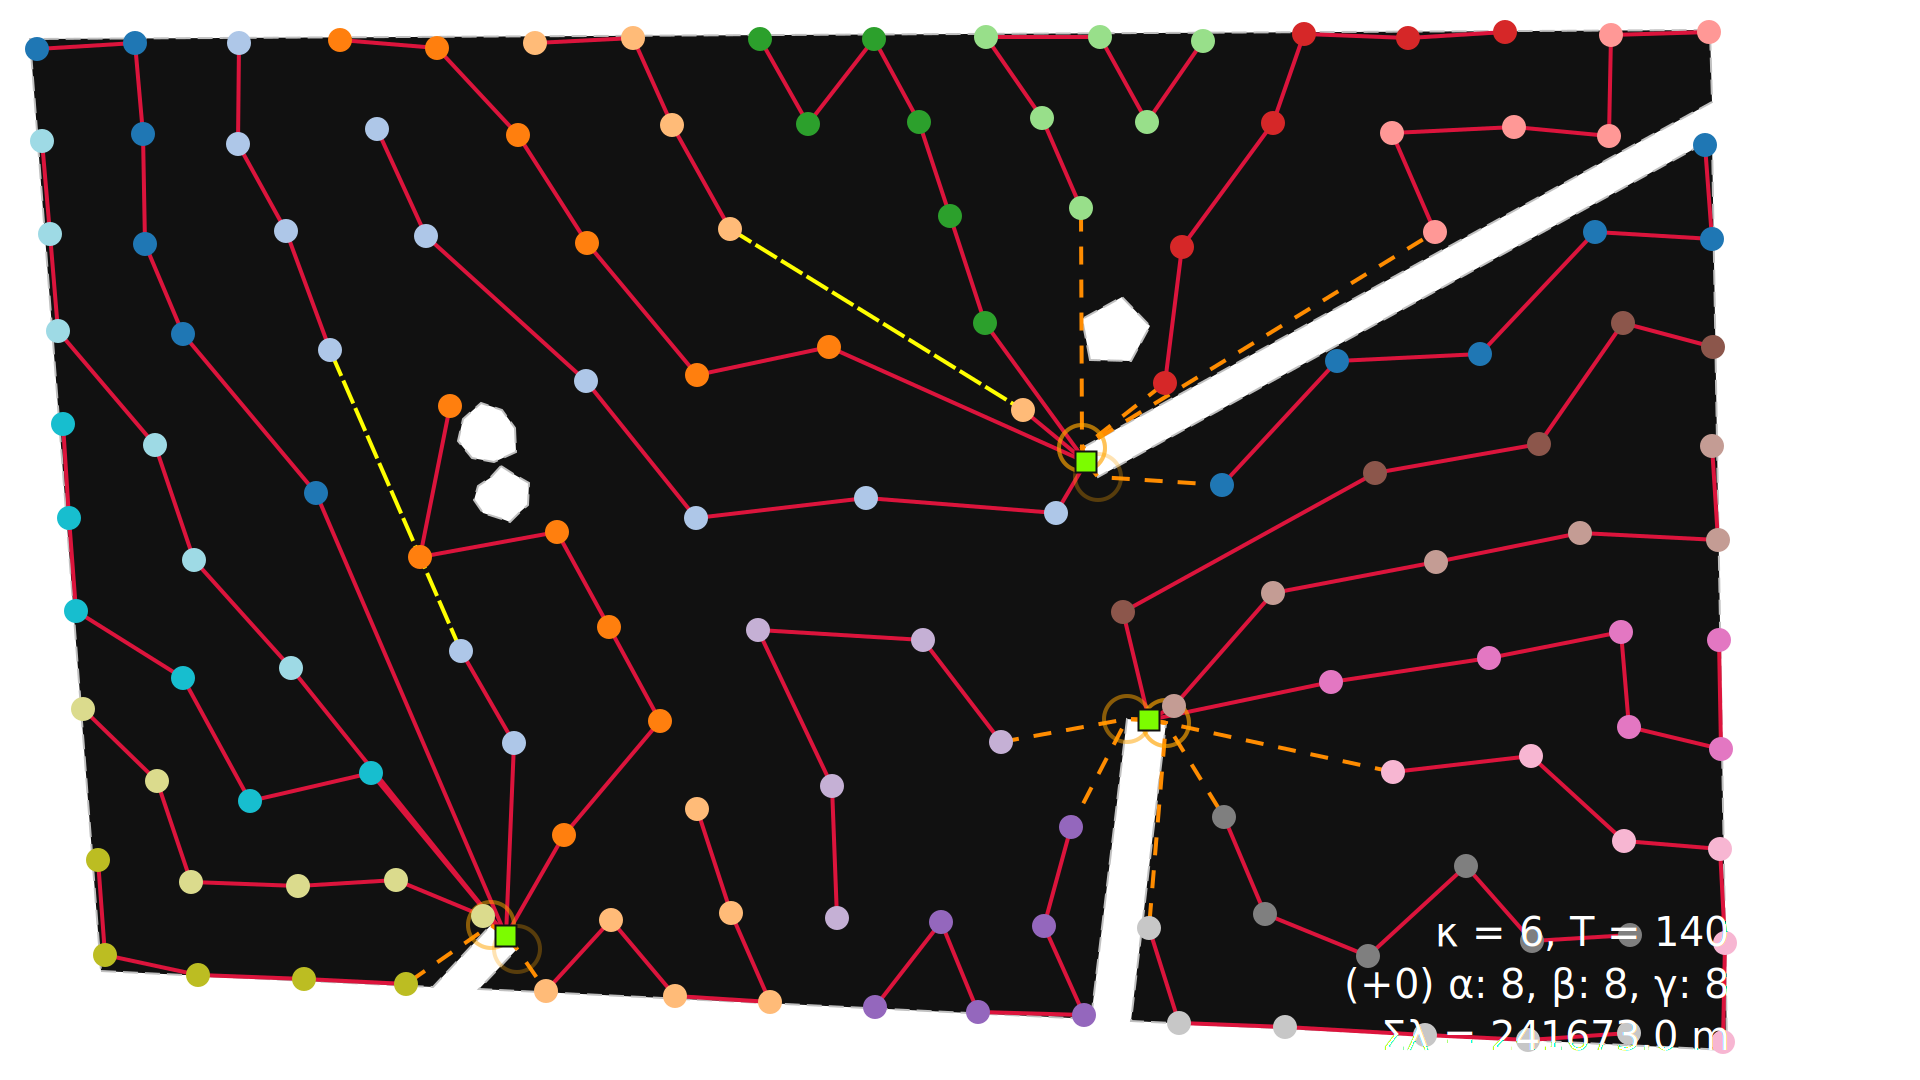

In [4]:
svgplot(G140_ref)

In [5]:
G210_ref = dill.load(open('data/cazzaro_2022G_210_paper_routeset.dill', 'rb'))

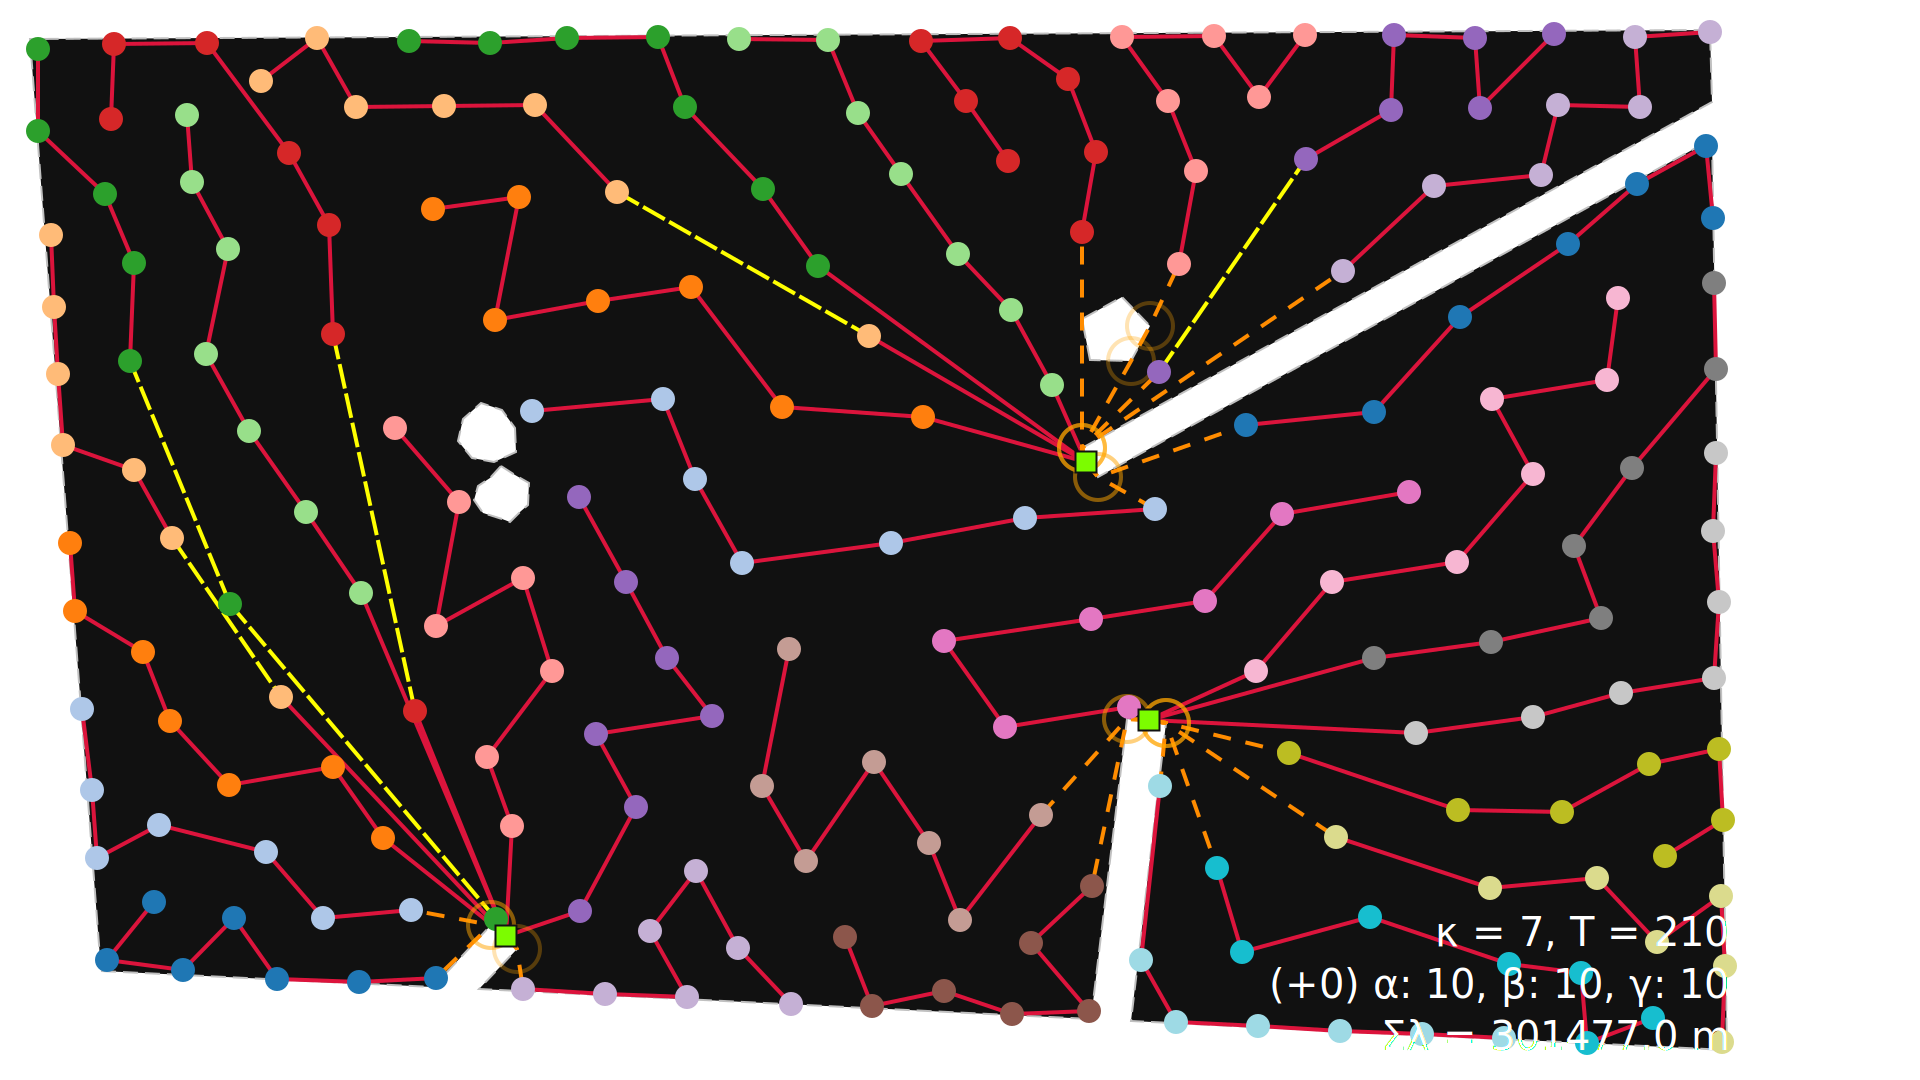

In [6]:
svgplot(G210_ref)

## Start here

## Instantiate solver

In [7]:
solver = solver_factory('gurobi')

## G-140, κ = 6

In [56]:
L140 = L_from_yaml(files('optiwindnet.data') / 'Cazzaro-2022G-140.yaml')

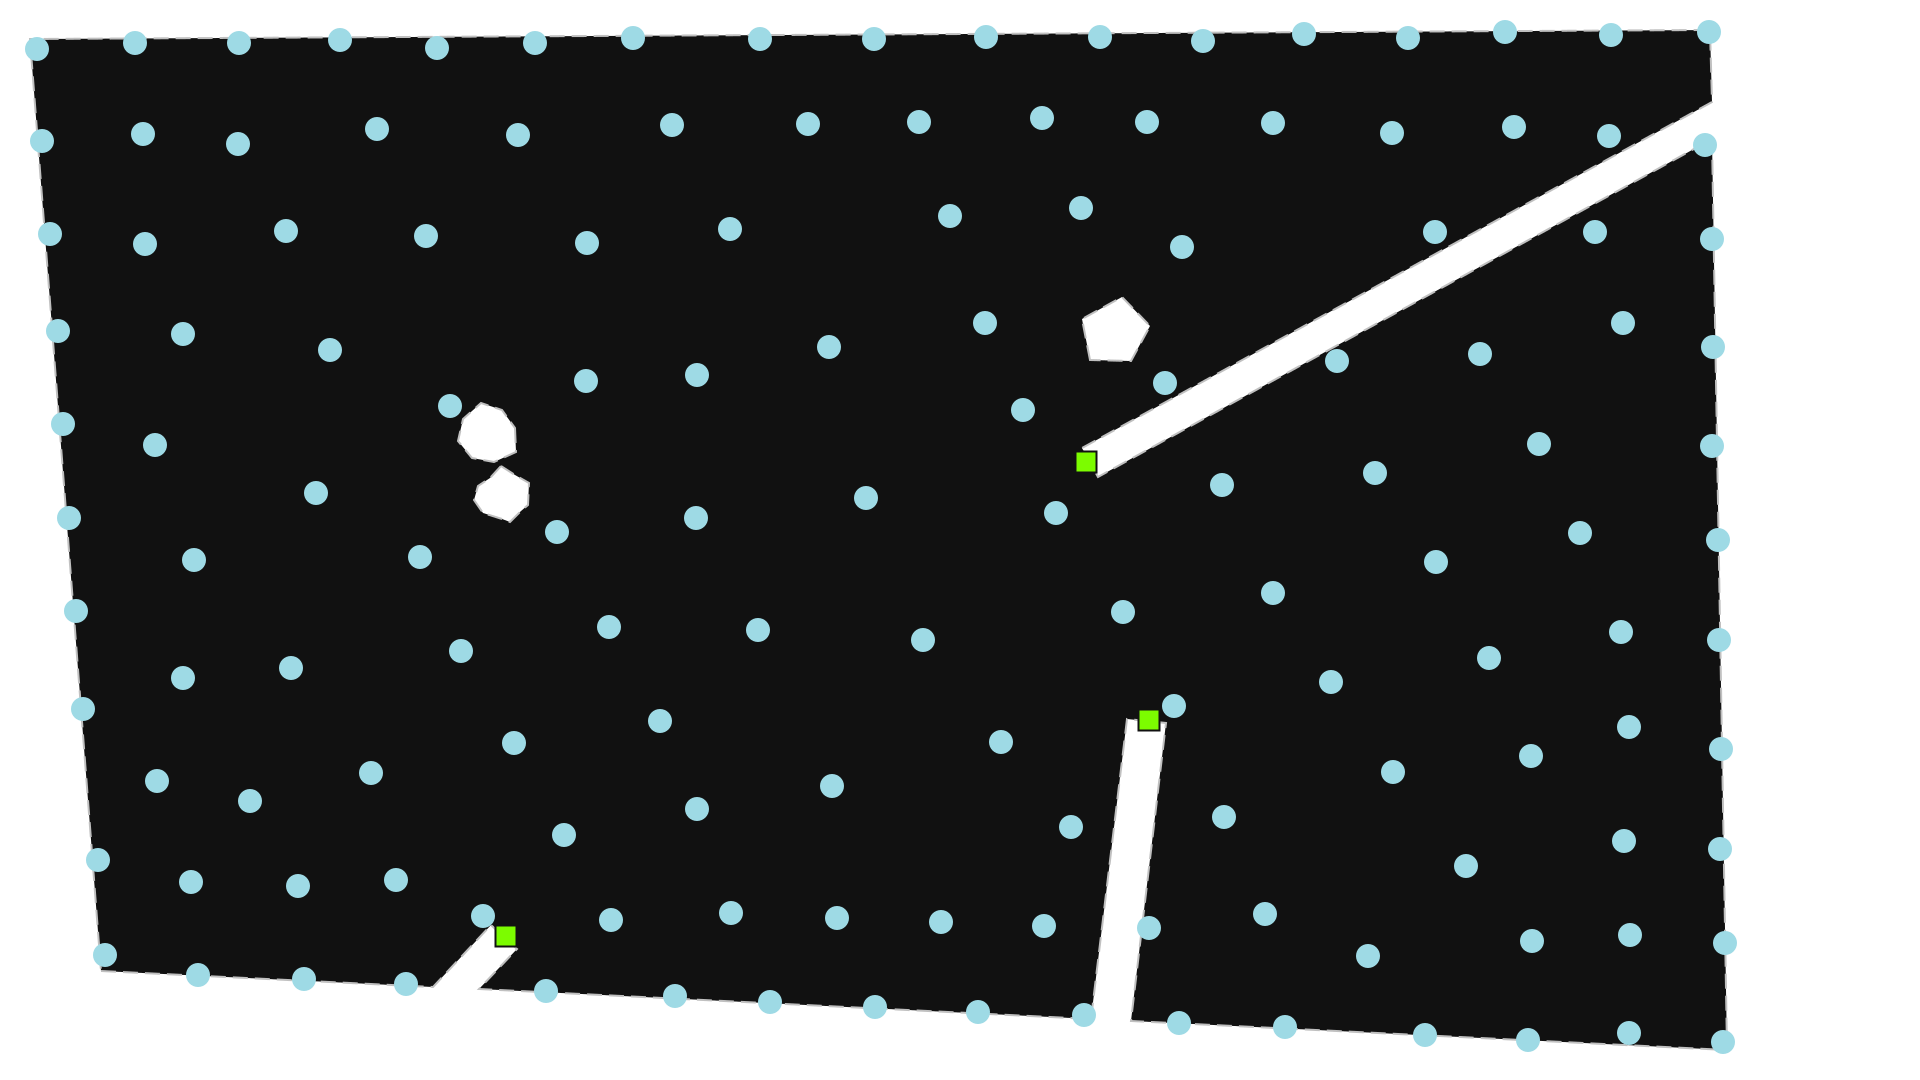

In [57]:
svgplot(L140)

In [58]:
P, A = make_planar_embedding(L140)
A_norm = as_normalized(A)

In [59]:
Sʹ = hgs_multiroot(A_norm, capacity=6, time_limit=0.5, balanced=True)

In [60]:
Sʹ.graph['solution_time']

(0.41, 0.04, 0.22)

In [61]:
Gʹ = G_from_S(Sʹ, A)

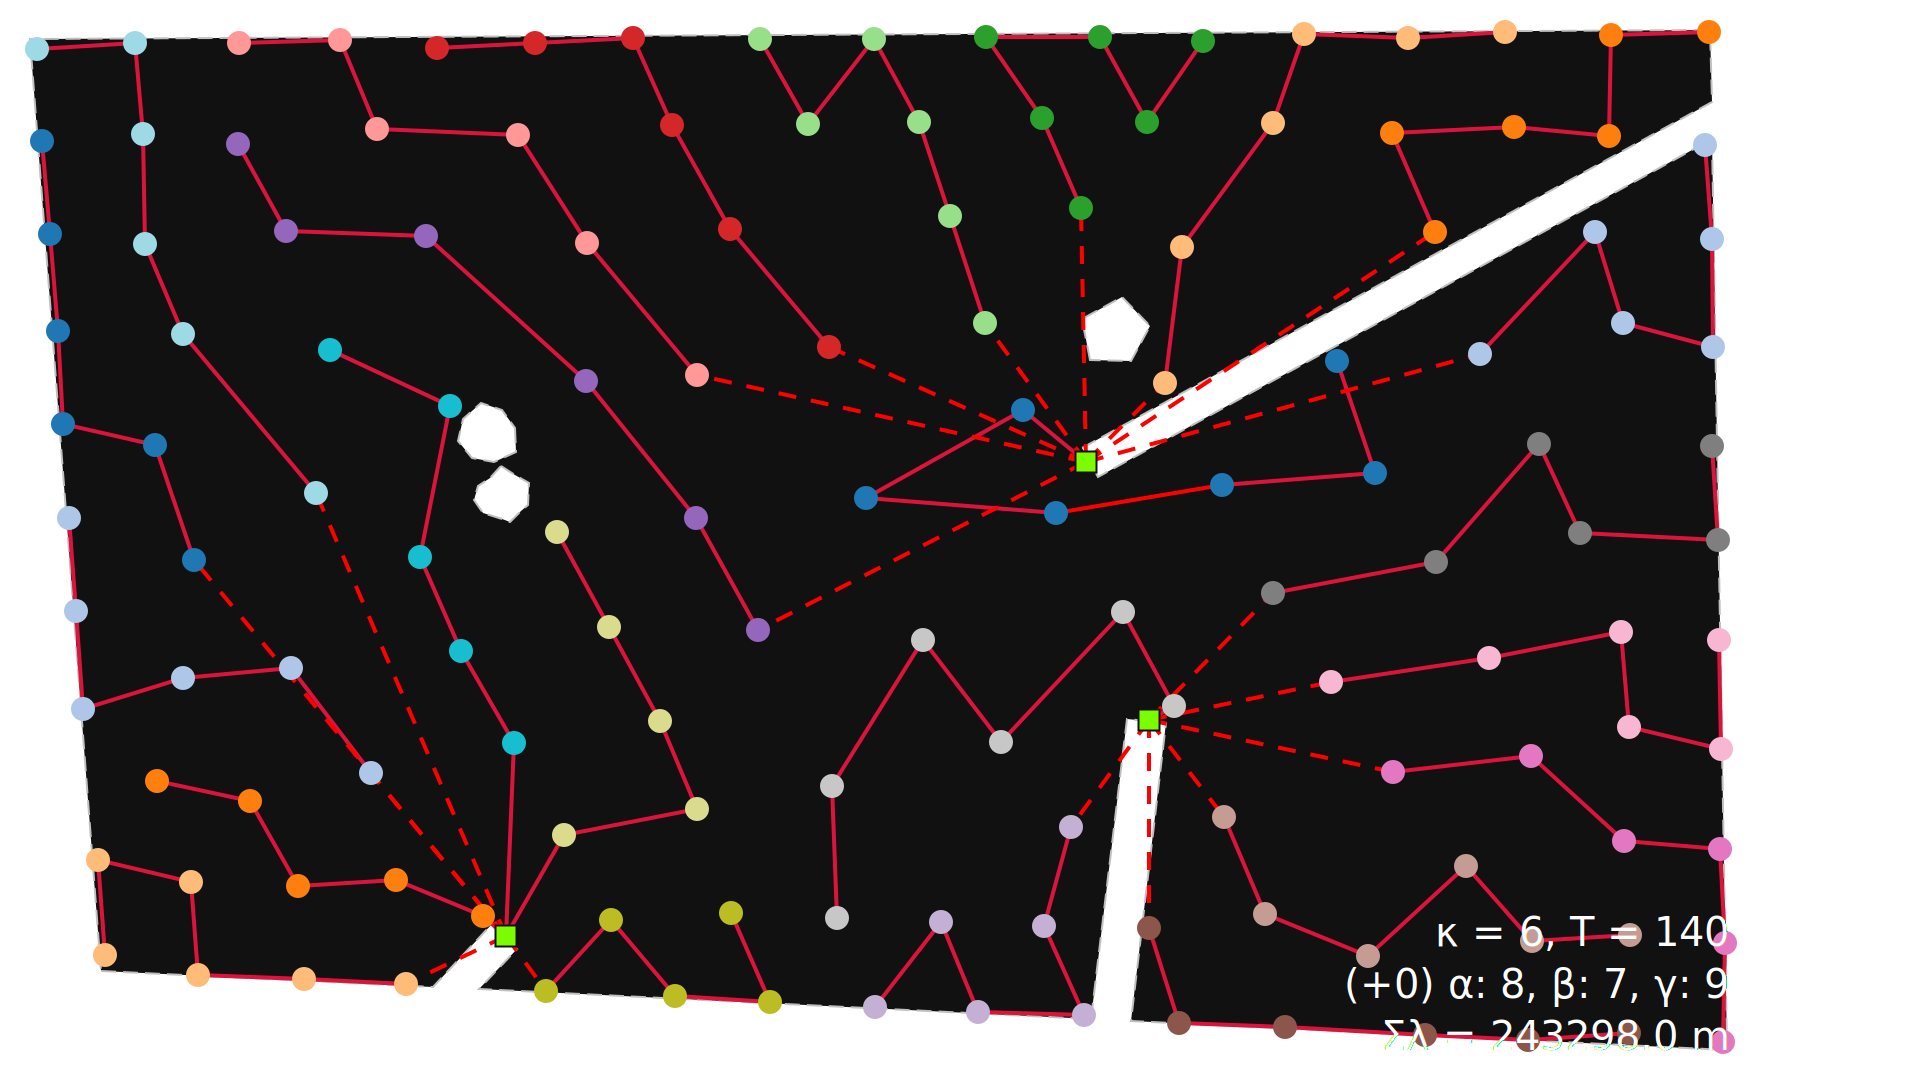

In [62]:
svgplot(Gʹ)

In [63]:
[[Sʹ[r][n]['load'] for n in Sʹ[r]] for r in range(-3, 0)]

[[6, 6, 6, 6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 6, 6, 6], [5, 5, 5, 6, 6, 6, 5, 6]]

In [64]:
Hʹ = PathFinder(Gʹ, planar=P, A=A, branched=False).create_detours()

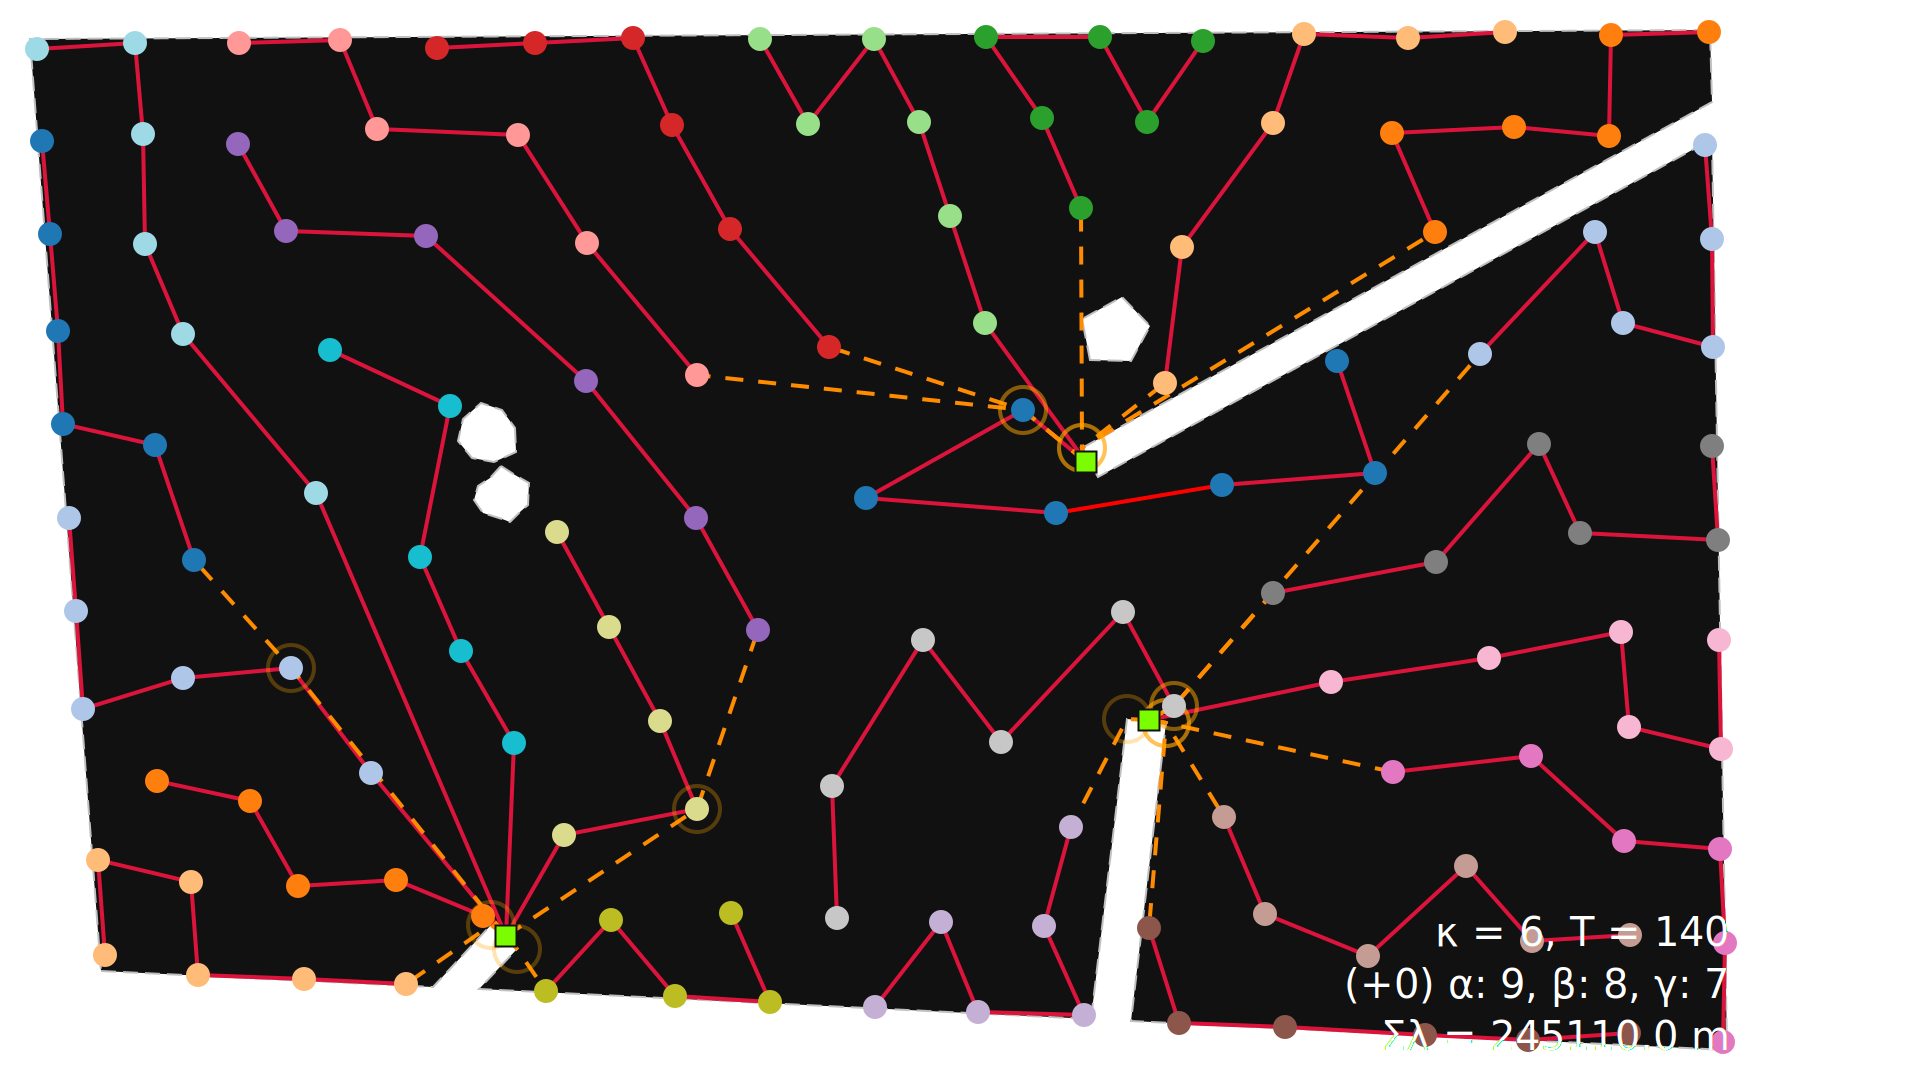

In [65]:
svgplot(Hʹ)

In [66]:
Hʹ.size(weight='length')/G140_ref.size(weight='length') - 1

0.01422305639439081

In [67]:
solver.set_problem(
    P, A,
    capacity=Sʹ.graph['capacity'],
    model_options=ModelOptions(
        topology="radial",
        feeder_route="segmented",
        feeder_limit="minimum",
        balanced=True,
    ),
    warmstart=Sʹ,
)

In [68]:
solver.solve(
    mip_gap=0.005,
    time_limit=10,
    verbose=True,
    options=dict(
        mipfocus=1,
        RINS=100,
        CutPasses=4,
        VarBranch=1,
    ),
)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  10
MIPGap  0.005
MIPFocus  1
RINS  100
VarBranch  1
CutPasses  4

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 5480 rows, 3388 columns and 21198 nonzeros
Model fingerprint: 0x96a337c4
Variable types: 0 continuous, 3388 integer (1694 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [4e+02, 2e+04]
  Bounds range     [1e+00, 6e+00]
  RHS range        [1e+00, 1e+02]

Loaded user MIP start with objective 243298

Presolve removed 967 rows and 0 columns
Presolve time: 0.02s
Presolved: 4513 rows, 3388 columns, 18426 nonzeros
Variable types: 0 continuous, 3388 integer (1694 b

SolutionInfo(runtime=10.043999910354614, bound=227336.5073120126, objective=236637.0856382203, relgap=0.03930313078832781, termination='maxTimeLimit')

In [69]:
S140, G140 = solver.get_solution()

In [70]:
[[G140[r][n]['load'] for n in G140[r]] for r in range(-3, 0)]

[[6, 6, 6, 6, 6, 6, 6, 5, 6, 6], [6, 6, 6, 5, 5, 6], [5, 6, 6, 6, 6, 6, 6, 6]]

In [71]:
1 - G140.size(weight='length')/G140_ref.size(weight='length')

0.020828468287038326

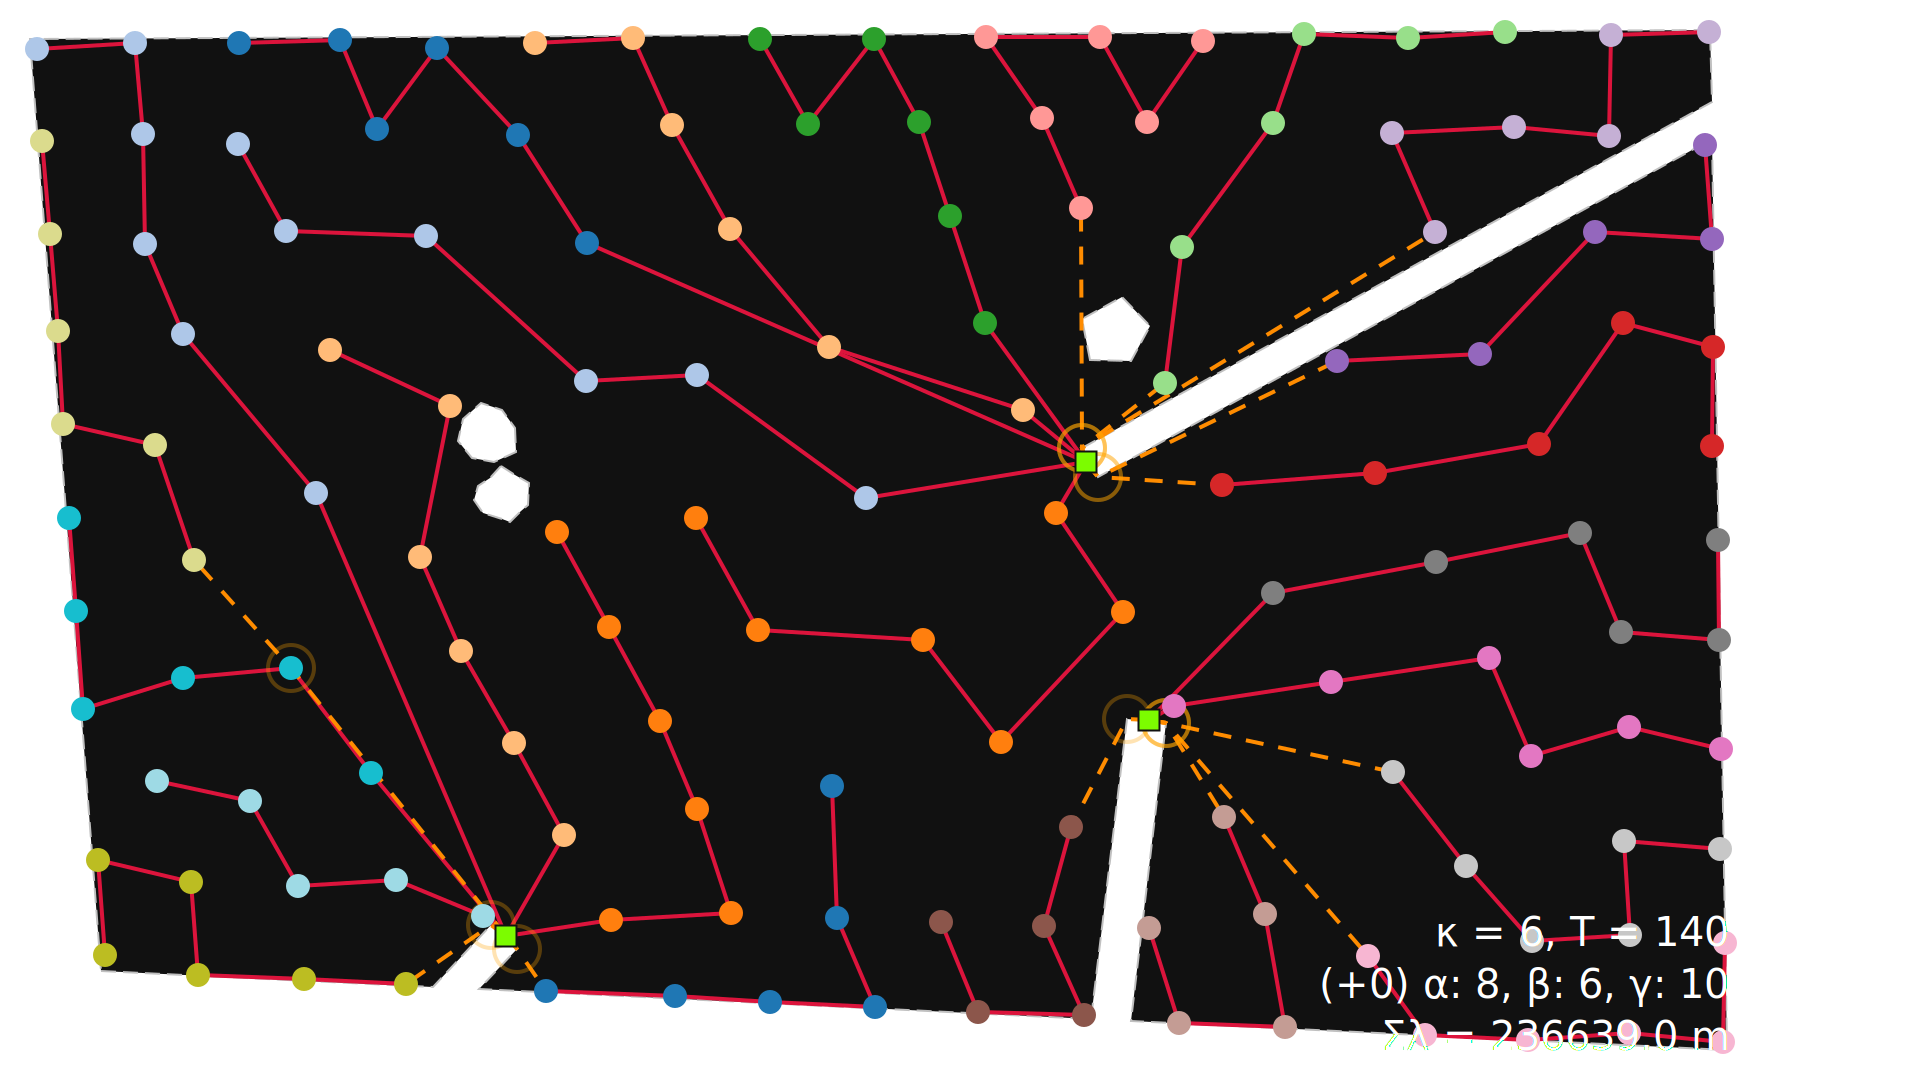

In [72]:
svgplot(G140)

In [73]:
with open('cazzaro_2022G_140_κ_6_radial_balanced_our.dill', 'wb') as outfile:
    dill.dump(G140, outfile)

## G-210, κ = 7

In [38]:
L210 = L_from_yaml(files('optiwindnet.data') / 'Cazzaro-2022G-210.yaml')

In [39]:
P, A = make_planar_embedding(L210)
A_norm = as_normalized(A)

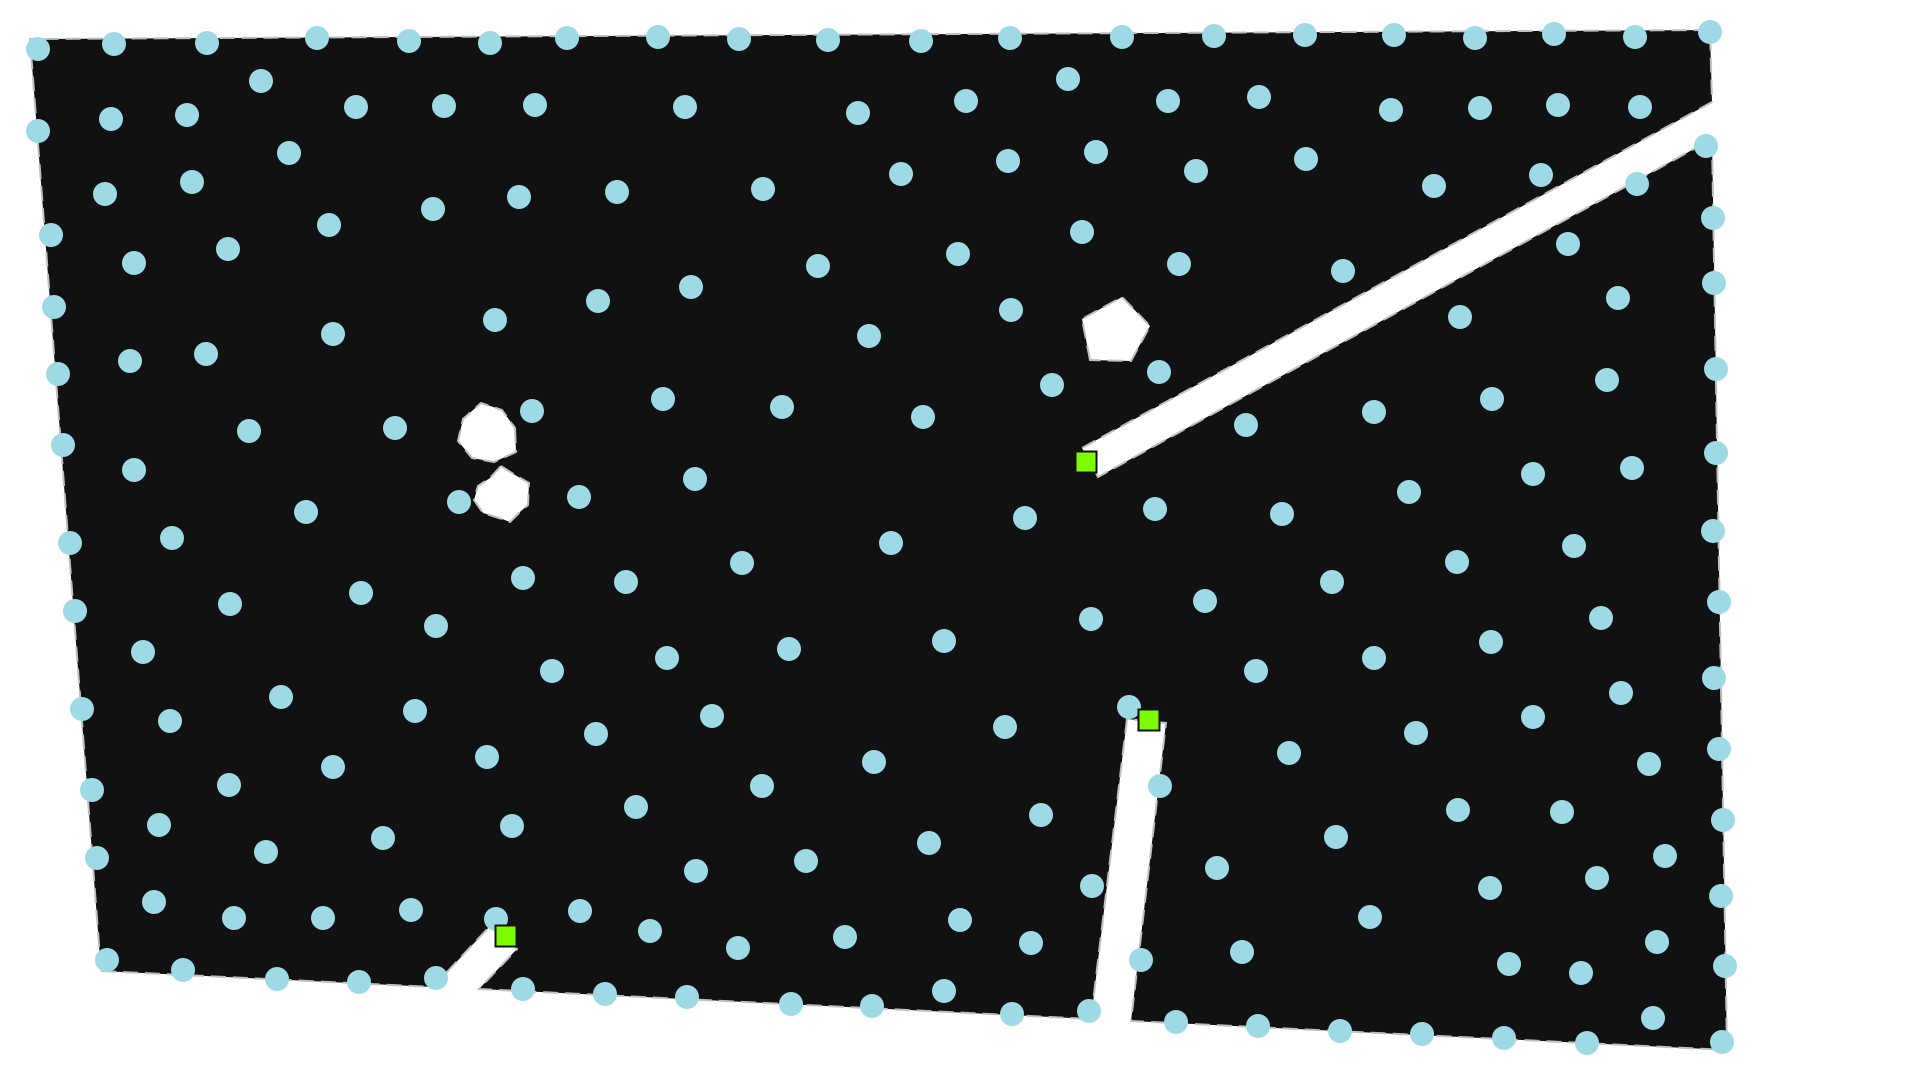

In [40]:
svgplot(L210)

In [41]:
Sʹ = hgs_multiroot(A_norm, capacity=7, time_limit=1)

In [42]:
Sʹ.graph['solution_time']

(0.35, 0.26, 0.33)

In [43]:
Gʹ = G_from_S(Sʹ, A)

In [44]:
Hʹ = PathFinder(Gʹ, planar=P, A=A, branched=False).create_detours()

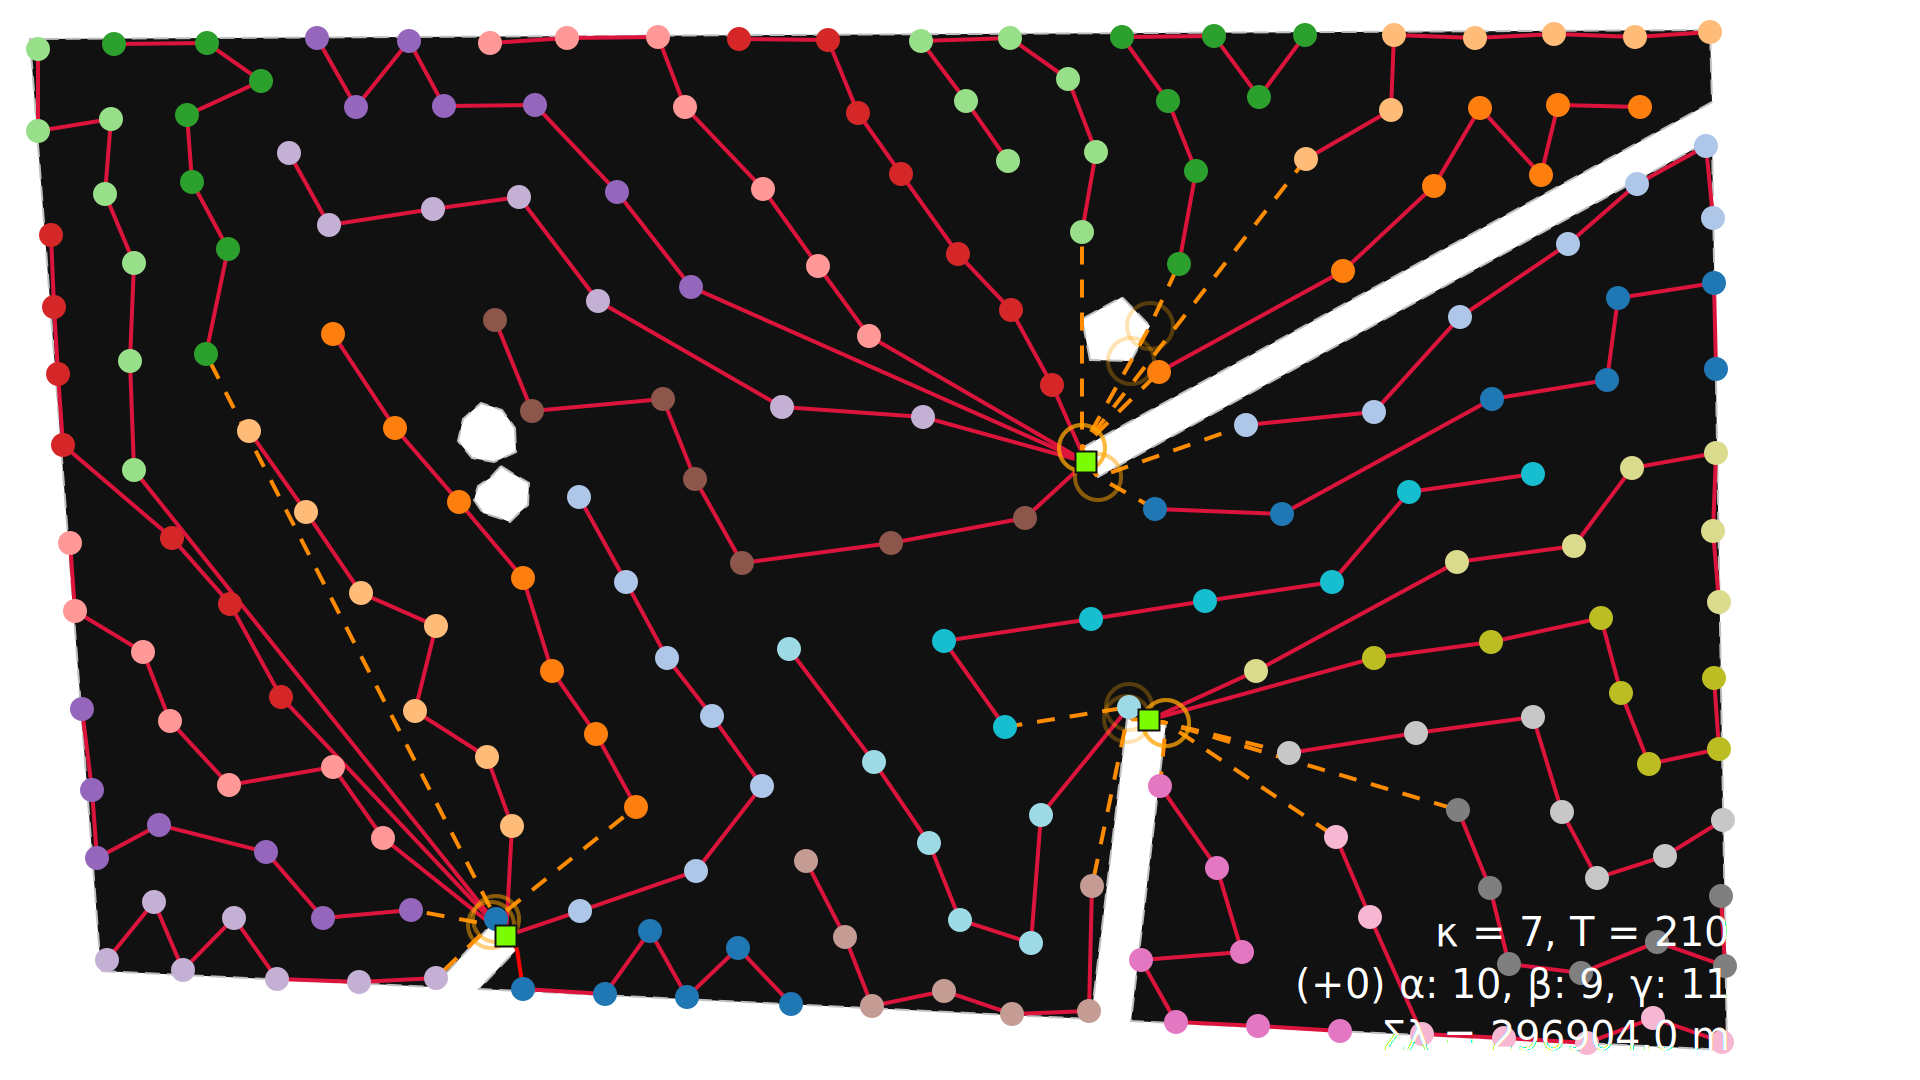

In [45]:
svgplot(Hʹ)

In [46]:
1- Hʹ.size(weight='length')/G210_ref.size(weight='length')

0.01517110172331404

### Solve the balanced MILP model

#### 90 s Gurobi

In [50]:
solver.set_problem(
    P, A,
    capacity=Sʹ.graph['capacity'],
    model_options=ModelOptions(
        topology="radial",
        feeder_route="segmented",
        feeder_limit="minimum",
        balanced=True,
    ),
    warmstart=Sʹ,
)

In [51]:
solver.solve(
    mip_gap=0.005,
    time_limit=90,
    verbose=True,
    options=dict(
        mipfocus=1,
        RINS=100,
        CutPasses=4,
        VarBranch=1,
    ),
)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  90
MIPGap  0.005
MIPFocus  1
RINS  100
VarBranch  1
CutPasses  4

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 7924 rows, 5304 columns and 32058 nonzeros
Model fingerprint: 0x68736103
Variable types: 0 continuous, 5304 integer (2652 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [3e+02, 2e+04]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 2e+02]

Loaded user MIP start with objective 296615

Presolve removed 891 rows and 0 columns
Presolve time: 0.09s
Presolved: 7033 rows, 5304 columns, 29018 nonzeros
Variable types: 0 continuous, 5304 integer (2652 b

SolutionInfo(runtime=90.0609998703003, bound=279393.2237340622, objective=294759.96552093467, relgap=0.05213306956293917, termination='maxTimeLimit')

In [52]:
S210, G210 = solver.get_solution()

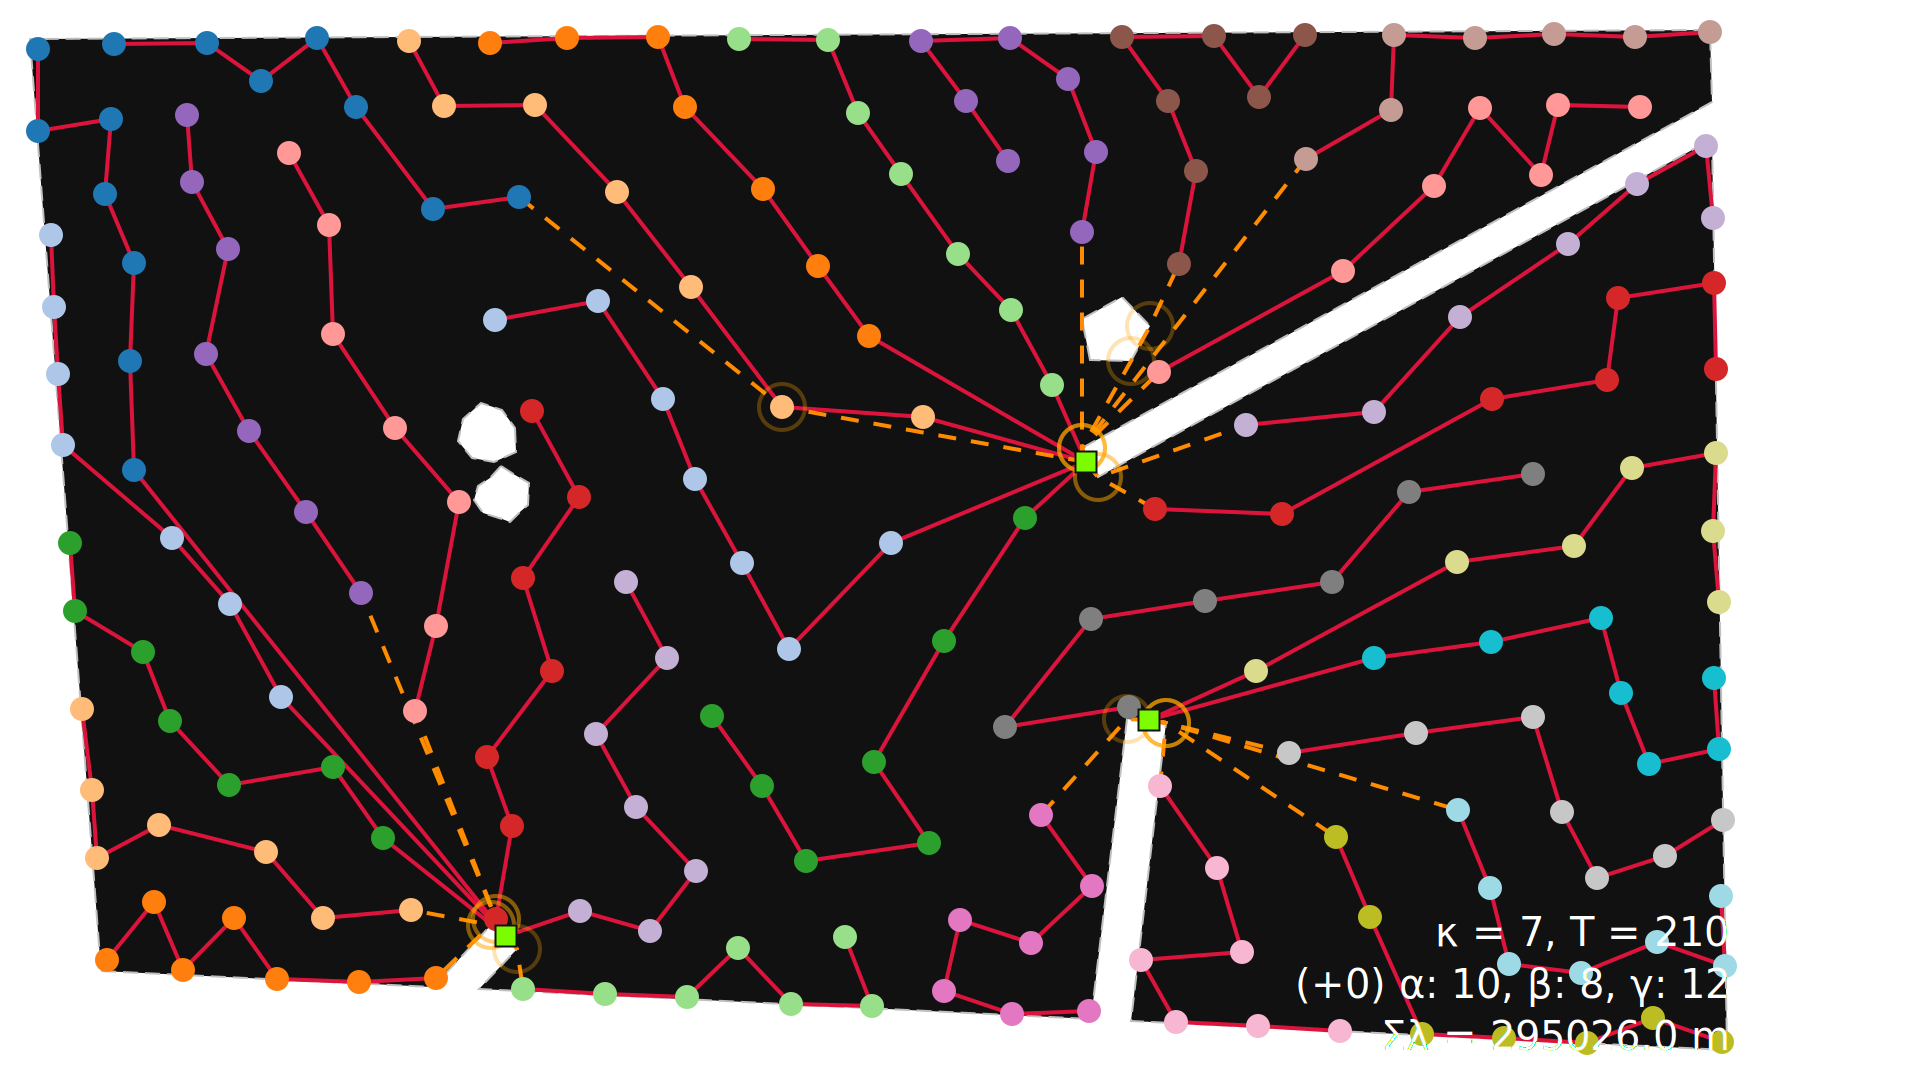

In [53]:
svgplot(G210)

In [54]:
1 - G210.size(weight='length')/G210_ref.size(weight='length')

0.02139847724499233

In [55]:
with open('cazzaro_2022G_210_κ_7_radial_balanced_our.dill', 'wb') as outfile:
    dill.dump(G210, outfile)